First we will use the [example from scikit-learn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html), then we will redo this example using Jacobian regularization

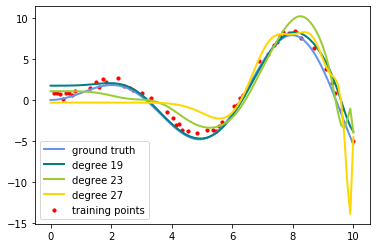

In [52]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)


# generate points used to plot
x_plot = np.linspace(0, 10, 100)

# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:50])
y = f(x) + np.random.rand(x.shape[0])

# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]

colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='red', s=10, marker='o', label="training points")

for count, degree in enumerate([19, 23, 27]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=300))
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

We see that for higher polynomial degrees we have a lot of overfitting. This is because Ridge regularization pushes all coefficients lower with the same force, whereas what we really want to accomplish is to make the function smoother, which means lowering the higher degree coefficients more, than the lower degree coefficients.

In [55]:
import tensorflow as tf
from keras.layers import BatchNormalization

In [3]:
#Defininng our placeholders
input_x = tf.placeholder(dtype='float', shape=(None,1))
input_y = tf.placeholder(dtype='float', shape=(None,1))

In [53]:
#Defining the functions
@tf.function
def approximator(x, coef):
    'This constructs a polynomial'
    z = x ** 0
    for i in range(1, coef.shape[0]):
        z = tf.concat([z, x ** i], axis=1)
    return BatchNormalization()(z) @ coef

@tf.function
def regularizer(x, coef):
    'This constructs a derivative of a polynomial'
    z = x ** 0
    for i in range(2, coef.shape[0]):
        z = tf.concat([z, i * x ** (i-1)], axis=1)
    return z @ coef[1:,:]

def loss(x, y, coef):
    'Loss without regularization'
    return (y - approximator(x, coef)) **2 / 2

def regularizer_loss(x, coef):
    return regularizer(x, coef)**2 / 2

def total_loss(x, y, coef, lambd):
    return loss(x, y, coef) + lambd * regularizer_loss(x, coef)

def total_cost(x, y, coef, lambd):
    return tf.reduce_mean(total_loss(x, y, coef, lambd), axis=0)

In [54]:
import unittest

class TestNotebook(unittest.TestCase):
    'This test will test the functions we use above'

    def test_approximator(self):
        'Test approximator function'
        values = np.arange(12).reshape(-1, 1)
        coef = tf.Variable([1., 2., 3.])
        coef = tf.reshape(coef, [-1,1])
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            result = sess.run(approximator(input_x, coef), feed_dict={input_x: values}).reshape((-1))
            self.assertAlmostEqual(result[4], 1+2*4+3*4**2)

    def test_regularizer(self):
        'Test approximator function'
        values = np.arange(12).reshape(-1, 1)
        coef = tf.Variable([1., 2., 3.])
        coef = tf.reshape(coef, [-1,1])
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            result = sess.run(regularizer(input_x, coef), feed_dict={input_x: values}).reshape((-1))
            self.assertAlmostEqual(result[4], 2+3*4*2)
            
    def test_loss(self):
        'Test loss function'
        values = np.array([4]).reshape(-1, 1)
        y_values = np.array([54]).reshape(-1, 1)
        coef = tf.Variable([1., 2., 3.])
        coef = tf.reshape(coef, [-1,1])
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            result = sess.run(loss(input_x, input_y, coef), 
                              feed_dict={input_x: values, input_y: y_values}).reshape((-1))
            self.assertAlmostEqual(result[0], 4.5)

    def test_regularizer_loss(self):
        'Test regularizer loss function'
        values = np.array([4]).reshape(-1, 1)
        coef = tf.Variable([1., 2., 3.])
        coef = tf.reshape(coef, [-1,1])
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            sess.run(init)
            result = sess.run(regularizer_loss(input_x, coef), 
                              feed_dict={input_x: values}).reshape((-1))
            self.assertAlmostEqual(result[0], 338)
            

unittest.main(argv=[''], verbosity=0, exit=False);

ERROR: test_approximator (__main__.TestNotebook)
Test approximator function
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-54-e2678c48d425>", line 14, in test_approximator
    result = sess.run(approximator(input_x, coef), feed_dict={input_x: values}).reshape((-1))
  File "C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\eager\def_function.py", line 414, in __call__
    self._initialize(args, kwds, add_initializers_to=initializer_map)
  File "C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\eager\def_function.py", line 357, in _initialize
    *args, **kwds))
  File "C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\eager\function.py", line 1349, in _get_concrete_function_internal_garbage_collected
    graph_function, _, _ = self._maybe_define_function(args, kwargs)
  File "C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\pytho

Trying Degree  9


ValueError: in converted code:

    <ipython-input-53-cac168eee125>:8 approximator *
        return BatchNormalization()(z) @ coef
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py:431 __call__ *
        self.build(unpack_singleton(input_shapes))
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\keras\layers\normalization.py:105 build *
        self.gamma = self.add_weight(shape=shape,
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\keras\legacy\interfaces.py:285 wrapper *
        return func(*args, **kwargs)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py:249 add_weight *
        weight = K.variable(initializer(shape),
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\keras\backend\tensorflow_backend.py:402 variable *
        v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\variables.py:259 __call__
        return cls._variable_v1_call(*args, **kwargs)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\variables.py:220 _variable_v1_call
        shape=shape)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\variables.py:59 getter
        return captured_getter(captured_previous, **kwargs)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\eager\def_function.py:345 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\variables.py:263 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\eager\def_function.py:159 __init__
        **unused_kwargs)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1750 __init__
        extra_handle_data=extra_handle_data)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:140 variable_handle_from_shape_and_dtype
        container=container)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py:1429 var_handle_op
        shared_name=shared_name, name=name)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\op_def_library.py:788 _apply_op_helper
        op_def=op_def)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\util\deprecation.py:507 new_func
        return func(*args, **kwargs)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:3616 create_op
        op_def=op_def)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:2027 __init__
        control_input_ops)
    C:\Users\michael\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\ops.py:1867 _create_c_op
        raise ValueError(str(e))

    ValueError: Duplicate node name in graph: 'batch_normalization_1/gamma'


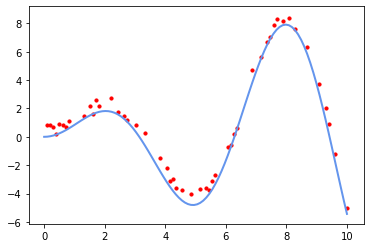

In [56]:
learning_rate = 100.0
lmbda = 0.0
n_epochs = 1001

plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='red', s=10, marker='o', label="training points")    


for count, degree in enumerate([9, 19, 23]):
    print('Trying Degree ', degree)
    coef = tf.Variable(initial_value=np.zeros((degree+1,1)), name="coef", dtype='float')
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    cost = total_cost(input_x, input_y, coef, lmbda)
    training_op = optimizer.minimize(cost)    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(n_epochs):
            if epoch % 100 == 0:
                print("Epoch", epoch, "Cost =", cost.eval(feed_dict={input_x: X.reshape(-1,1), input_y: y.reshape(-1,1) }))
            #print(coef.eval().reshape(-1))
            sess.run(training_op, feed_dict={input_x: X.reshape(-1,1), input_y: y.reshape(-1,1) })
        
        y_plot = approximator(input_x, coef).eval(feed_dict={input_x: X_plot.reshape(-1,1)})
        
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()
